# Setup

In [6]:
import sys
!{sys.executable} -m pip install numpy scipy wfdb matplotlib

  Using cached wfdb-4.0.0-py3-none-any.whl (161 kB)
  Using cached soundfile-0.11.0-py2.py3-none-any.whl (23 kB)


In [31]:
import os
import configparser

import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import savgol_filter
from scipy.io import savemat

import wfdb

from denoising import preprocess

In [32]:
config = configparser.ConfigParser()
config.read('../../config.ini')

['../../config.ini']

In [33]:
PROJECT_DIR = config.get('PATHS', 'PROJECT_PATH')
RAW_DATA_DIR = os.path.join(PROJECT_DIR, 'data/raw/fecgsyndb-1.0.0')
INTERIM_MECG_DATA_DIR = os.path.join(PROJECT_DIR, 'data/interim/mecg/fecgsyndb-1.0.0')
INTERIM_FECG_DATA_DIR = os.path.join(PROJECT_DIR, 'data/interim/fecg/fecgsyndb-1.0.0')

os.makedirs(RAW_DATA_DIR, exist_ok=True)
os.makedirs(INTERIM_MECG_DATA_DIR, exist_ok=True)
os.makedirs(INTERIM_FECG_DATA_DIR, exist_ok=True)

SAMPLING_RATE = 250

(75000, 34)
{'fs': 250, 'sig_len': 75000, 'n_sig': 34, 'base_date': None, 'base_time': None, 'units': ['nu', 'nu', 'nu', 'nu', 'nu', 'nu', 'nu', 'nu', 'nu', 'nu', 'nu', 'nu', 'nu', 'nu', 'nu', 'nu', 'nu', 'nu', 'nu', 'nu', 'nu', 'nu', 'nu', 'nu', 'nu', 'nu', 'nu', 'nu', 'nu', 'nu', 'nu', 'nu', 'nu', 'nu'], 'sig_name': ['ECG', 'ECG', 'ECG', 'ECG', 'ECG', 'ECG', 'ECG', 'ECG', 'ECG', 'ECG', 'ECG', 'ECG', 'ECG', 'ECG', 'ECG', 'ECG', 'ECG', 'ECG', 'ECG', 'ECG', 'ECG', 'ECG', 'ECG', 'ECG', 'ECG', 'ECG', 'ECG', 'ECG', 'ECG', 'ECG', 'ECG', 'ECG', 'ECG', 'ECG'], 'comments': ['n:300000', 'fhr:143.0077', 'mhr:107.7705', 'mtypeacc:nsr', 'ftypeacc:nsr', 'SNRfm:-11.3619', 'mheart:2.0944 0.2000 0.4000', 'fheart:-0.3110 0.3342 -0.3849', 'refpos:3.1416 0.5000 -0.3000', 'SNRmn:12', 'macc:0', 'facc:0', 'maccmean:0', 'maccstd:1', 'faccmean:0.0000', 'faccstd:1.0000', 'ftraj:none', 'fname:aecg', 'mres:0.3375', 'fres:0.9541', 'mvcg:6', 'fvcg:2', 'evcg:3', 'posdev:1', 'mectb:0', 'fectb:0', 'nfetus:1', 'nnoise

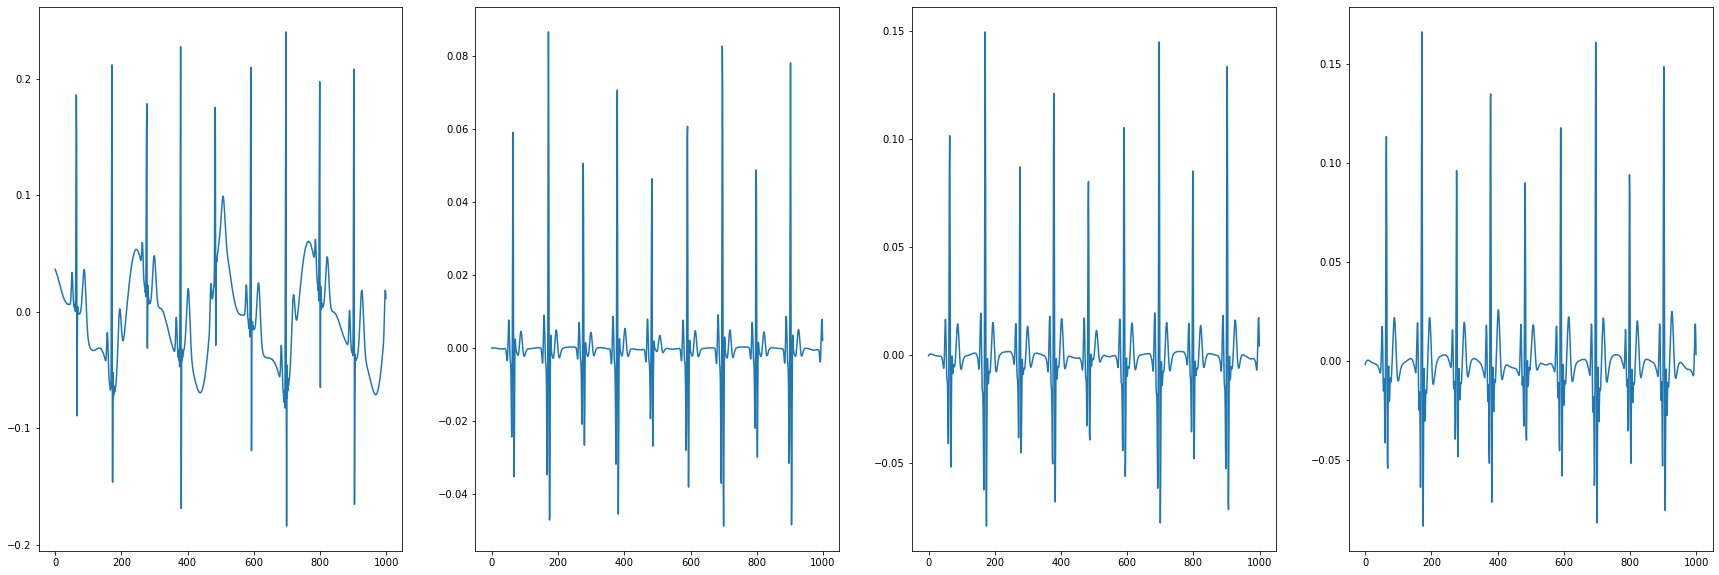

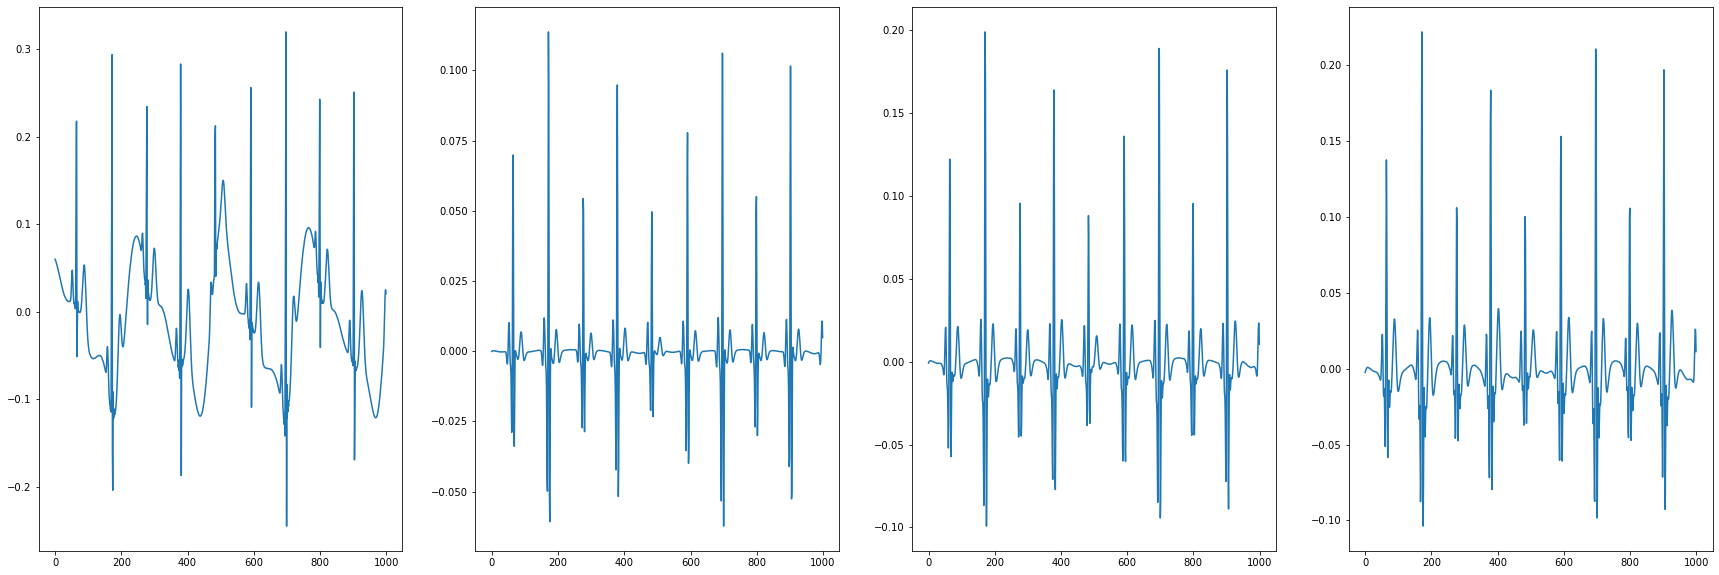

In [34]:
test_file = f'{RAW_DATA_DIR}/sub01/snr12dB/sub01_snr12dB_l1_fecg1'
signal, ext = wfdb.rdsamp(test_file) #signal is a 75000x34 matrix

print(signal.shape)
print(ext)
start = 1
dif = 10

for i in range(2): #plot 10 channels
    _, ax = plt.subplots(1,4, figsize = (30, 10))
    ax[0].plot(signal[10000:11000,i])
    for j in range(1, 4):
        chan, _ = preprocess(signal[:,i], SAMPLING_RATE, numtaps=start+dif*j)
        ax[j].plot(chan[10000:11000])
    plt.show()

In [35]:
def get_filenames_syndb(data_dir : str = RAW_DATA_DIR) -> np.ndarray:
    '''returns a 10 (patients) x 5 (snr levels) x y (physiological levels, status) x 5 (repetition) x 75000 (250 Hz x 5 min) x 34 (channels)'''
    x1 = []
    for patient in range(1,11): # patient number
        x2 = []
        for snr in range(5): # noise level

            x3 = {}
            patient_noise_dir = f'{data_dir}/sub{patient:02}/snr{snr*3:02}dB'
            fnames = [f for f in os.listdir(patient_noise_dir)] # fnames is unsorted, should sort x3 after
            fnames_trunc = set([fname[:-4] for fname in fnames])
            seen_fnames = set()

            for fname in fnames_trunc: # for all fnames, may be of any trial
                if f'{fname[:13]}{fname[17:]}' in seen_fnames: # if same combination of diff trial was seen
                    continue

                seen_fnames.add(f'{fname[:13]}{fname[17:]}') # add current combination
                x4 = [] # list of all the trials
                for i in range(1, 6): # for each trial
                    x4.append(f'{patient_noise_dir}/{fname[:13]}_l{i}_{fname[17:]}')
                
                assert len(x4) == 5

                x3[fname[17:]] = x4 # x4 is sorted by trial

            x2.append(x3)

        x1.append(x2)

    return np.array(x1, dtype = object)

In [36]:
filenames = get_filenames_syndb()

In [37]:
filenames.shape

(10, 5)

In [38]:
filenames[0][0].keys()

dict_keys(['c0_noise1', 'c3_mecg', 'c5_mecg', 'c5_fecg1', 'c2_noise2', 'c4_noise1', 'c2_mecg', 'c1_noise2', 'c1_mecg', 'c4_noise2', 'c3_noise1', 'c5_noise1', 'mecg', 'c5_noise2', 'c3_noise3', 'c0_mecg', 'c2_noise1', 'c4_fecg1', 'c3_fecg1', 'c4_mecg', 'c1_fecg1', 'c1_noise1', 'c0_fecg1', 'c3_noise2', 'c0_noise2', 'c5_fecg2', 'fecg1', 'c2_fecg1'])

In [39]:
filenames[0][0]['c1_mecg']

['/home/rchong3/git/FECG-extraction/data/raw/fecgsyndb-1.0.0/sub01/snr00dB/sub01_snr00dB_l1_c1_mecg',
 '/home/rchong3/git/FECG-extraction/data/raw/fecgsyndb-1.0.0/sub01/snr00dB/sub01_snr00dB_l2_c1_mecg',
 '/home/rchong3/git/FECG-extraction/data/raw/fecgsyndb-1.0.0/sub01/snr00dB/sub01_snr00dB_l3_c1_mecg',
 '/home/rchong3/git/FECG-extraction/data/raw/fecgsyndb-1.0.0/sub01/snr00dB/sub01_snr00dB_l4_c1_mecg',
 '/home/rchong3/git/FECG-extraction/data/raw/fecgsyndb-1.0.0/sub01/snr00dB/sub01_snr00dB_l5_c1_mecg']

In [40]:
samp, samp_info = wfdb.rdsamp(filenames[0][1]['c1_mecg'][0])
print(samp, samp_info)

[[ 0.039       0.04333333  0.04766667 ...  0.03133333  0.05766667
   0.14      ]
 [ 0.09833333  0.11033333  0.12133333 ...  0.081       0.14466667
   0.36566667]
 [ 0.13766667  0.15466667  0.17066667 ...  0.11666667  0.201
   0.528     ]
 ...
 [ 0.12833333  0.03066667 -0.086      ... -0.397       0.618
  -1.984     ]
 [-0.47633333 -0.59766667 -0.72566667 ... -0.676      -0.436
  -3.08966667]
 [-0.52666667 -0.62833333 -0.73233333 ... -0.60766667 -0.609
  -2.735     ]] {'fs': 250, 'sig_len': 75000, 'n_sig': 34, 'base_date': None, 'base_time': None, 'units': ['nu', 'nu', 'nu', 'nu', 'nu', 'nu', 'nu', 'nu', 'nu', 'nu', 'nu', 'nu', 'nu', 'nu', 'nu', 'nu', 'nu', 'nu', 'nu', 'nu', 'nu', 'nu', 'nu', 'nu', 'nu', 'nu', 'nu', 'nu', 'nu', 'nu', 'nu', 'nu', 'nu', 'nu'], 'sig_name': ['ECG', 'ECG', 'ECG', 'ECG', 'ECG', 'ECG', 'ECG', 'ECG', 'ECG', 'ECG', 'ECG', 'ECG', 'ECG', 'ECG', 'ECG', 'ECG', 'ECG', 'ECG', 'ECG', 'ECG', 'ECG', 'ECG', 'ECG', 'ECG', 'ECG', 'ECG', 'ECG', 'ECG', 'ECG', 'ECG', 'ECG', 'E

In [41]:
samp.shape

(75000, 34)

In [42]:
print(sorted(filenames[0][0].keys()))

['c0_fecg1', 'c0_mecg', 'c0_noise1', 'c0_noise2', 'c1_fecg1', 'c1_mecg', 'c1_noise1', 'c1_noise2', 'c2_fecg1', 'c2_mecg', 'c2_noise1', 'c2_noise2', 'c3_fecg1', 'c3_mecg', 'c3_noise1', 'c3_noise2', 'c3_noise3', 'c4_fecg1', 'c4_mecg', 'c4_noise1', 'c4_noise2', 'c5_fecg1', 'c5_fecg2', 'c5_mecg', 'c5_noise1', 'c5_noise2', 'fecg1', 'mecg']


In [43]:
noise, noise_info = wfdb.rdsamp(filenames[0][0]['c1_noise2'][0])
print(noise, noise_info)

[[-0.001      -0.00066667 -0.00033333 ...  0.00066667 -0.00133333
   0.        ]
 [ 0.00166667  0.002       0.00233333 ...  0.00133333  0.002
   0.00233333]
 [ 0.00333333  0.00333333  0.003      ... -0.00033333  0.00433333
   0.002     ]
 ...
 [ 0.00166667  0.00133333  0.00066667 ... -0.00133333  0.00233333
  -0.00033333]
 [ 0.00066667  0.00033333  0.00033333 ... -0.00033333  0.00066667
   0.        ]
 [ 0.00033333  0.00066667  0.00133333 ...  0.00133333  0.00033333
   0.00133333]] {'fs': 250, 'sig_len': 75000, 'n_sig': 34, 'base_date': None, 'base_time': None, 'units': ['nu', 'nu', 'nu', 'nu', 'nu', 'nu', 'nu', 'nu', 'nu', 'nu', 'nu', 'nu', 'nu', 'nu', 'nu', 'nu', 'nu', 'nu', 'nu', 'nu', 'nu', 'nu', 'nu', 'nu', 'nu', 'nu', 'nu', 'nu', 'nu', 'nu', 'nu', 'nu', 'nu', 'nu'], 'sig_name': ['ECG', 'ECG', 'ECG', 'ECG', 'ECG', 'ECG', 'ECG', 'ECG', 'ECG', 'ECG', 'ECG', 'ECG', 'ECG', 'ECG', 'ECG', 'ECG', 'ECG', 'ECG', 'ECG', 'ECG', 'ECG', 'ECG', 'ECG', 'ECG', 'ECG', 'ECG', 'ECG', 'ECG', 'ECG', '

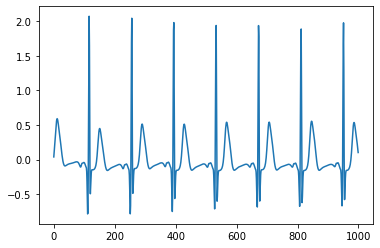

In [44]:
plt.plot(samp[:1000,0])
plt.show()

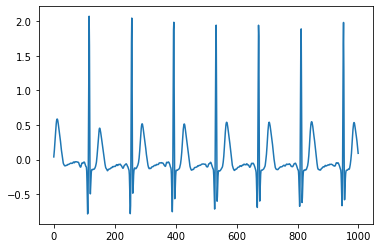

In [45]:
plt.plot(samp[:1000,0] + noise[:1000,0])
plt.show()

In [46]:
ann = wfdb.rdann(filenames[0][0]['fecg1'][0], extension='qrs')
ann

In [47]:
ann.sample.shape

(715,)

In [72]:
def load_ecg_syndb(fname : str) -> np.ndarray:
    signal, _ = wfdb.rdsamp(fname)
    return signal.transpose()

In [49]:
def load_comments_syndb(fname : str) -> np.ndarray:
    _, info = wfdb.rdsamp(fname)
    return info['comments']

In [50]:
def load_qrs_syndb(fname : str) -> np.ndarray:
    ann = wfdb.rdann(fname, extension='qrs')
    return ann.sample

# fECG Filtering Analysis

In [51]:
preprocess_params = {}

## FIR Filter

In [52]:
preprocess_params['winlen'] = 0
preprocess_params['polyorder'] = 0
preprocess_params['wavelet'] = ''
preprocess_params['lvl'] = 0

In [ ]:
preprocess_params['numtaps'] = 0

subject_subset = [0]
snr_subset = [0]
rep_subset = [0]
chan_subset = [0]

taps_delta = 10
taps_start = 11

fecg_keys = [k for k in filenames[0][0].keys() if 'fecg' in k]

for i in subject_subset:
    for j in snr_subset:
        for k in fecg_keys:
            for l in rep_subset:
                signals = load_ecg_syndb(filenames[i][j][k][l])
                for chan in chan_subset:
                    sig_window = signals[chan]
                    fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(30, 4))
                    axs[0].set_title(f'{os.path.basename(filenames[i][j][k][l])} Channel {chan}')
                    axs[0].plot(sig_window[:1000])
                    for m in range(1, 5):
                        taps = taps_delta * (m - 1) + taps_start
                        preprocessed_signal, _ = preprocess(sig_window, SAMPLING_RATE, numtaps=taps)
                        axs[m].set_title(f'{taps} taps')
                        axs[m].plot(preprocessed_signal[:1000])
                    plt.show()

In [75]:
preprocess_params['numtaps'] = 21

# Filter fECG and Save

In [76]:
def save_fecg_syndb(filenames : np.ndarray, preprocess_params : dict, data_dir : str = INTERIM_FECG_DATA_DIR):
    fecg_keys = [k for k in filenames[0][0].keys() if 'fecg' in k]
    total = filenames.shape[0] * filenames.shape[1]
    for i in range(filenames.shape[0]):
        for j in range(filenames.shape[1]):
            print(filenames.shape[1] * i + j, '/', total,)
            for k in fecg_keys:
                for l in range(len(filenames[i][j][k])):
                    fname = filenames[i][j][k][l]
                    raw_signals = load_ecg_syndb(fname)
                    comments = load_comments_syndb(fname)
                    qrs = load_qrs_syndb(fname)
                    filt_signals = np.copy(raw_signals)
                    for chan in range(raw_signals.shape[0]):
                        filt_signals[chan], _ = preprocess(raw_signals[chan], SAMPLING_RATE, **preprocess_params)
                    split_name = fname.split('_')
                    d = {'comments': comments, 'fs': SAMPLING_RATE, 'filtered' : filt_signals, 'lightly_filtered' : raw_signals, 'raw' : raw_signals + load_ecg_syndb('_'.join(split_name[:-1]) + '_noise2') if 'c' in split_name[-2] else raw_signals, 'peaks' : qrs}
                    savemat(file_name=os.path.join(data_dir, os.path.basename(fname)), mdict=d)

In [ ]:
save_fecg_syndb(filenames, preprocess_params)

0 / 50
1 / 50


# mECG Filtering Analysis

In [ ]:
preprocess_params = {}

## FIR Filter

In [ ]:
preprocess_params['winlen'] = 0
preprocess_params['polyorder'] = 0
preprocess_params['wavelet'] = ''
preprocess_params['lvl'] = 0

In [ ]:
preprocess_params['numtaps'] = 0

subject_subset = [0]
snr_subset = [0, 4]
rep_subset = [0]
chan_subset = [0]

taps_delta = 10
taps_start = 11

mecg_keys = [k for k in filenames[0][0].keys() if 'mecg' in k]

for i in subject_subset:
    for j in snr_subset:
        for k in mecg_keys:
            for l in rep_subset:
                signals = load_ecg_syndb(filenames[i][j][k][l])
                for chan in chan_subset:
                    sig_window = signals[chan]
                    fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(30, 4))
                    axs[0].set_title(f'{os.path.basename(filenames[i][j][k][l])} Channel {chan}')
                    axs[0].plot(sig_window[:1000])
                    for m in range(1, 5):
                        taps = taps_delta * (m - 1) + taps_start
                        preprocessed_signal, _ = preprocess(sig_window, SAMPLING_RATE, numtaps=taps)
                        axs[m].set_title(f'{taps} taps')
                        axs[m].plot(preprocessed_signal[:1000])
                    plt.show()

In [ ]:
preprocess_params['numtaps'] = 21

# Filter mECG and Save

In [ ]:
def save_mecg_syndb(filenames : np.ndarray, preprocess_params : dict, data_dir : str = INTERIM_MECG_DATA_DIR):
    mecg_keys = [k for k in filenames[0][0].keys() if 'mecg' in k]
    total = filenames.shape[0] * filenames.shape[1]
    for i in range(filenames.shape[0]):
        for j in range(filenames.shape[1]):
            for k in mecg_keys:
                for l in range(len(filenames[i][j][k])):
                    fname = filenames[i][j][k][l]
                    raw_signals = load_ecg_syndb(fname)
                    filt_signals = np.copy(raw_signals)
                    for chan in range(raw_signals.shape[0]):
                        filt_signals[chan], _ = preprocess(raw_signals[chan], SAMPLING_RATE, **preprocess_params)
                    split_name = fname.split('_')
                    d = {'fs': SAMPLING_RATE, 'filtered' : filt_signals, 'raw' : raw_signals + load_ecg_syndb('_'.join(split_name[:-1]) + '_noise1') if 'c' in split_name[-2] else raw_signals}
                    savemat(file_name=os.path.join(data_dir, os.path.basename(fname)), mdict=d)

In [ ]:
save_mecg_syndb(filenames, preprocess_params)